# Ex 10.1 Feature Hashing

In [72]:
import json

path_to_folder = "/Users/GretarAtli/Documents/GitHub/Dtu/Dtu-ToolsForBigData/week_10/ex10/data"
name = '/reuters-'

file_paths = []

for i in range(3):
    for j in range(10):
        if i== 2 and j > 1:
            break
    
        file_paths.append(path_to_folder  + name + '0' + str(i) + str(j) + '.json')   

topics = []
bodies = []

# Read in the data
for path in file_paths:
    with open(path) as json_data:
        d = json.load(json_data)
        for di in d:
            try:
                topic = di['topics']
                body = di['body']
                # Check if earn is part of the topics
                if "earn" in topic:
                    topics.append(1)
                else:
                    topics.append(0)
                bodies.append(body)
            except:
                pass
            


In [160]:
import numpy as np
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.cross_validation import train_test_split
from sklearn.ensemble import RandomForestClassifier

# Create raw bag-of-words encoding.
cv = CountVectorizer(stop_words="english", lowercase=True)
bag_of_words_matrix = cv.fit_transform(bodies)
bag_of_words_matrix.toarray()

# Split the data into training and testing set
x_train,x_test,y_train,y_test = train_test_split( bag_of_words_matrix, topics, test_size=0.2)

# Now we are ready to use the random forest classifier
clf = RandomForestClassifier(n_estimators=50)
clf.fit(x_train, y_train)
y_predicte = clf.predict(x_test)

# Report the score
print ("The score is {}".format(
    np.sum( np.array(y_test) == np.array(y_predicte) ) / len(np.array(y_test))
    ))

print ("The score with .score function ={}".format(
        clf.score(x_test,y_test)
    ))


The score is 0.96676300578
The score with .score function =0.96676300578


In [159]:
# Now we implement feature hashing and use 1000 buckets instead of the raw bag-of-words encoding.

# First we implement the hashing vectorizer
def hashing_vectorizer(features, N):
    x = np.zeros(N)
    for f in features:
        h = hash(f)
        x[h % N] += 1
        
    return x

# initialize the feature hashing matrix
N = 1000 # number of buckets
feature_hasing_matrix = np.zeros((len(bodies), N))

for i,_ in enumerate(feature_hasing_matrix):
    feature_hasing_matrix[i] = hashing_vectorizer(bodies[i],N)
    
# know we use this matrix to train our machine learning algorithm

# Split the data into training and testing set
x_train,x_test,y_train,y_test = train_test_split( feature_hasing_matrix, topics, test_size=0.2)

# Now we are ready to use the random forest classifier
clf = RandomForestClassifier(n_estimators=50)
clf.fit(x_train, y_train)
y_predicte = clf.predict(x_test)

# Report the score
print ("The score is {}".format(
    np.sum( np.array(y_test) == np.array(y_predicte) ) / len(np.array(y_test))
    ))


The score is 0.93063583815


# Exercise 10.2 (LSH)
Implement the LSH algorithm from the lecture to hash images (so that similar images get similar hashes). Show that it works with an example or two.


In [168]:
import cv2


from PIL import Image
img = Image.open('cat.png').convert('LA')
img = img.resize((9,8))
img.save('cat_greyscaleless.png')



from PIL import Image
img_rednose = Image.open('cat_rednose.png').convert('LA')
img_rednose = img.resize((9,8))
img_rednose.save('cat_greyscaleless_rednose.png')


In [233]:
import cv2 # for this I needed to install opencv -> pip install opencv-python


def getHashLshAlgorithm(img):
    # Resize to 9x8 pixels
    img = cv2.resize(img,(9,8))

    # Compare adjacent values (x>y)
    img_compared = np.empty((8,8))

    for i,row in enumerate(img):
        for j,column in enumerate(row):
            if j + 1 == len(row):
                break
            else:
                img_compared[i][j] = row[j] > row[j+1]

    hash_string = ""
    for difference in img_compared:
        decimal_value = 0
        hex_string = []
        for index, value in enumerate(difference):
            if value:
                decimal_value += 2**(index % 8)
            if (index % 8) == 7:
                hex_string.append(hex(decimal_value)[2:].rjust(2, '0'))
                decimal_value = 0
        hash_string = hash_string +''.join(hex_string) + ' ' 
    return hash_string


filenames = ['cat.png', 'cat_mod.png','cat_mod_more.png','cat_orange.png']

for name in filenames:
    print "The hash for the figure {}:".format(name)
    print getHashLshAlgorithm(cv2.imread(name, cv2.IMREAD_GRAYSCALE))


# Grayscale the image
#img_cat = cv2.imread('cat.png', cv2.IMREAD_GRAYSCALE)
#img_cat_mod = cv2.imread('cat_mod.png', cv2.IMREAD_GRAYSCALE)
#img_cat_mod_more = cv2.imread('cat_mod_more.png', cv2.IMREAD_GRAYSCALE)
#img_cat_orange = cv2.imread('cat_orange.png', cv2.IMREAD_GRAYSCALE)



The hash for the figure cat.png:
14 02 07 00 82 31 4b 03 
The hash for the figure cat_mod.png:
14 02 07 00 82 31 4b 03 
The hash for the figure cat_mod_more.png:
14 1a 07 10 82 31 4b 03 
The hash for the figure cat_orange.png:
00 20 44 41 43 b7 21 00 


answer for cat          = 14 02 07 00 82 31 4b 03

answer for cat mod      = 14 02 07 00 82 31 4b 03

answer for cat mod more = 14 1a 07 10 82 31 4b 03

In [229]:
getHashLshAlgorithm(cv2.imread('cat_orange.png', cv2.IMREAD_GRAYSCALE))

'0020444143b72100'

In [230]:
getHashLshAlgorithm(cv2.imread('cat.png', cv2.IMREAD_GRAYSCALE))

'1402070082314b03'

In [222]:
differences = [[False, False, True, True, False, False, True, False],[False, True, True, False, False, True, False, False],[True, True, False, False, True, False, False, False],[True, False, False, True, False, False, False, True],[False, False, True, False, False, False, True, True],[False, True, False, False, False, True, True, False],[True, False, False, False, True, True, False, False],[False, False, False, True, True, False, False, True]]
for difference in differences:
	decimal_value = 0
	hex_string = []
	for index, value in enumerate(difference):
		if value:
			decimal_value += 2**(index % 8)
		if (index % 8) == 7:
			hex_string.append(hex(decimal_value)[2:].rjust(2, '0'))
			decimal_value = 0
	print ''.join(hex_string),

4c 26 13 89 c4 62 31 98


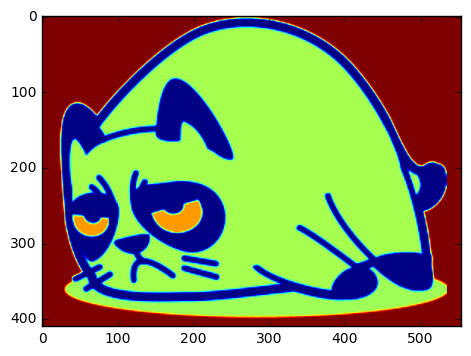

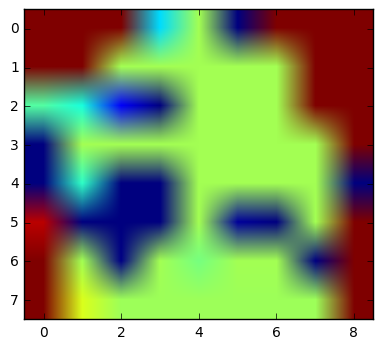

In [235]:
import cv2 # for this I needed to install opencv -> pip install opencv-python
import matplotlib.pyplot as plt
import matplotlib.image as mpimg

# Grayscale the image
img = cv2.imread('cat.png', cv2.IMREAD_GRAYSCALE)
plt.imshow(img)
plt.show()

# Resize to 9x8 pixels
img = cv2.resize(img,(9,8))
plt.imshow(img)
plt.show()